In [23]:
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize
mpl.rcParams['figure.dpi'] = 200
plt.style.use('ggplot')
%matplotlib inline

from adjustText import adjust_text

import numpy as np
import pandas as pd
import seaborn as sns
sns.set('poster')

from nba_api.stats.endpoints import (
    leaguedashplayerstats,
    leaguedashteamstats,
    commonteamroster,
    commonplayerinfo,
    leaguestandings
)
from nba_api.stats.static import teams, players
from nba_api.stats.library.parameters import PerModeDetailed, MeasureTypeDetailedDefense

In [47]:
df = leaguedashteamstats.LeagueDashTeamStats(per_mode_detailed=PerModeDetailed.per_game, season='2018-19', measure_type_detailed_defense=MeasureTypeDetailedDefense.advanced).get_data_frames()[0]
df_basic = leaguedashteamstats.LeagueDashTeamStats(per_mode_detailed=PerModeDetailed.per_game, season='2018-19', measure_type_detailed_defense=MeasureTypeDetailedDefense.base).get_data_frames()[0]
standings = leaguestandings.LeagueStandings().get_data_frames()[0].rename(str, columns={'TeamID': 'TEAM_ID'})
df['SHORT_NAME'] = df['TEAM_ID'].apply(lambda team_id: teams.find_team_name_by_id(team_id)['abbreviation'])
df = df.merge(standings, on='TEAM_ID')
cols_to_merge = list(df_basic.columns.difference(df.columns)) + ['TEAM_ID']
df = df.merge(df_basic[cols_to_merge], on='TEAM_ID')

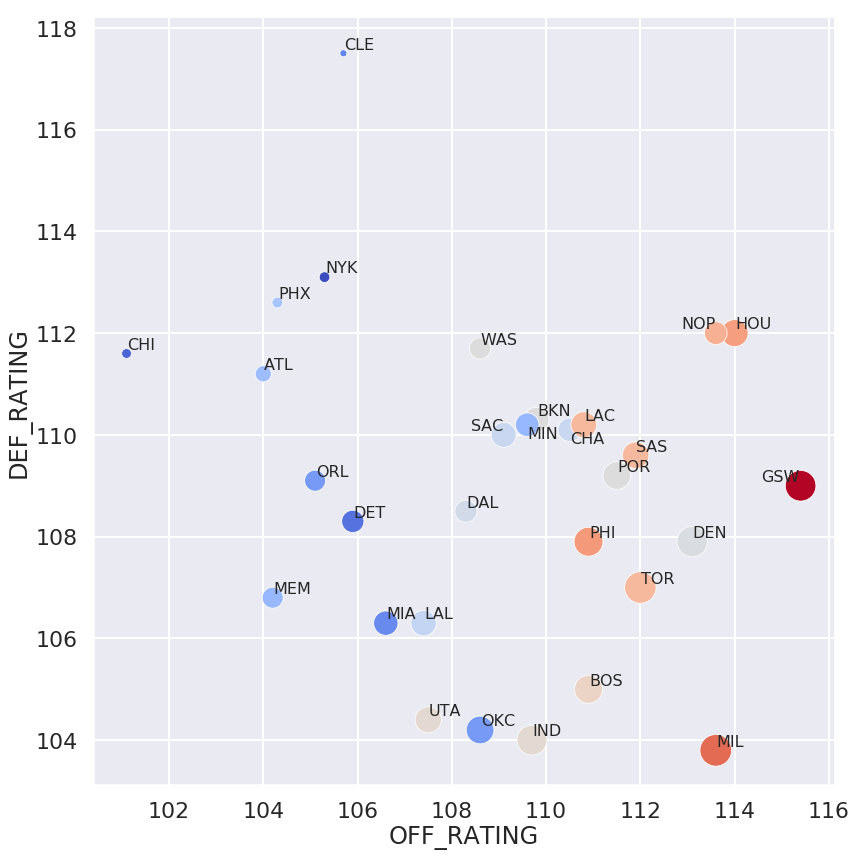

In [3]:
sns.relplot(data=df, x='OFF_RATING', y='DEF_RATING', hue='TS_PCT', size='W_PCT', sizes=(50, 1000), 
            palette='coolwarm', legend=None, height=12, aspect=1)

texts = []
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        texts.append(ax.text(point['x'], point['y'], str(point['val']), fontsize=16))

label_point(df.OFF_RATING, df.DEF_RATING, df.SHORT_NAME, plt.gca())
adjust_text(texts);

In [4]:
%%capture
sorted_net = df[['SHORT_NAME', 'NET_RATING', 'TS_PCT', 'OFF_RATING_RANK', 'DEF_RATING_RANK']]
sorted_net['LBL'] = sorted_net.apply(lambda row: f"{row.SHORT_NAME} ({row.OFF_RATING_RANK}/{row.DEF_RATING_RANK})", axis=1)
sorted_net.set_index('LBL', inplace=True)
sorted_net.sort_values('NET_RATING', inplace=True)

cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=np.min(sorted_net.TS_PCT), vmax=np.max(sorted_net.TS_PCT))

sorted_net['colors'] = sorted_net.TS_PCT.apply(lambda x: cmap(norm(x)))

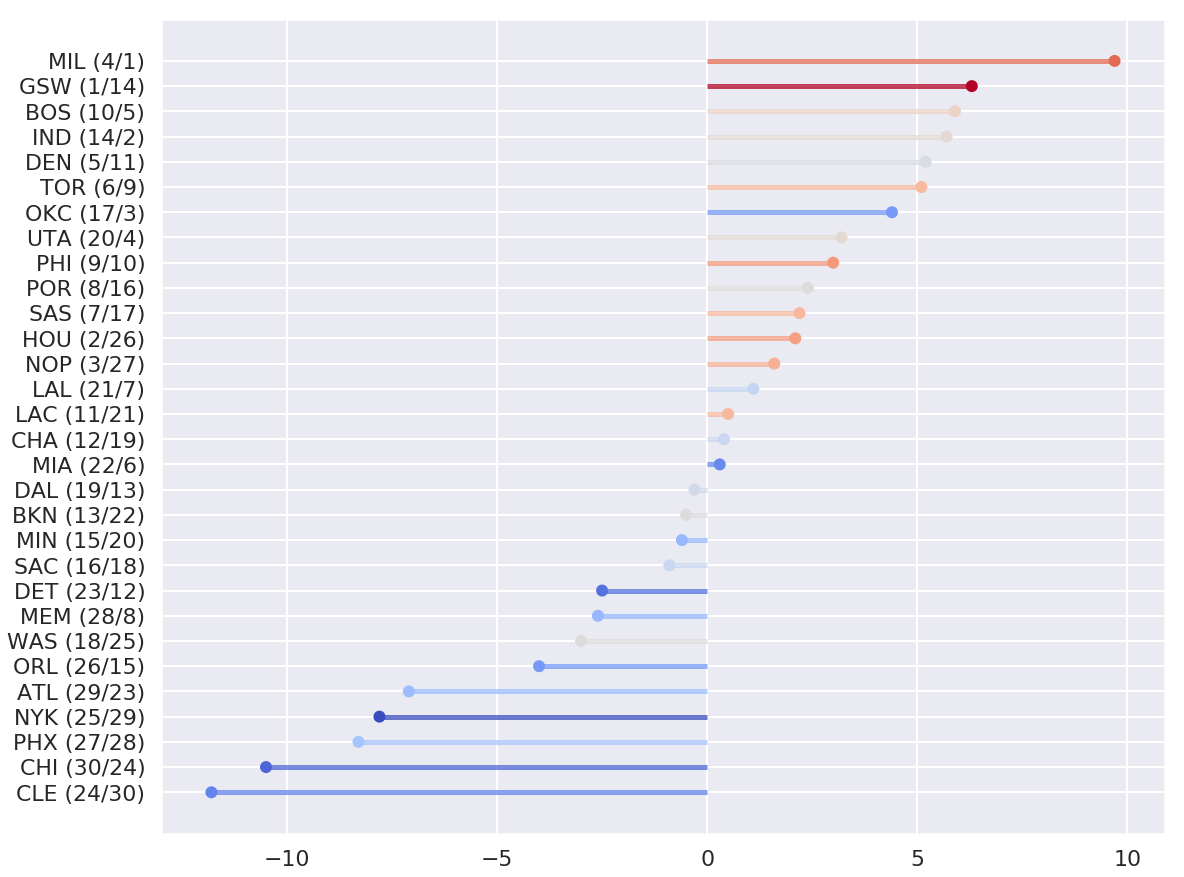

In [5]:
# Draw plot
plt.figure(figsize=(18,15))
plt.hlines(y=sorted_net.index, xmin=0, xmax=sorted_net.NET_RATING, color=sorted_net.colors, alpha=0.75, linewidth=5)
plt.scatter(sorted_net.NET_RATING, sorted_net.index, s=100, alpha=1, color=sorted_net.colors)

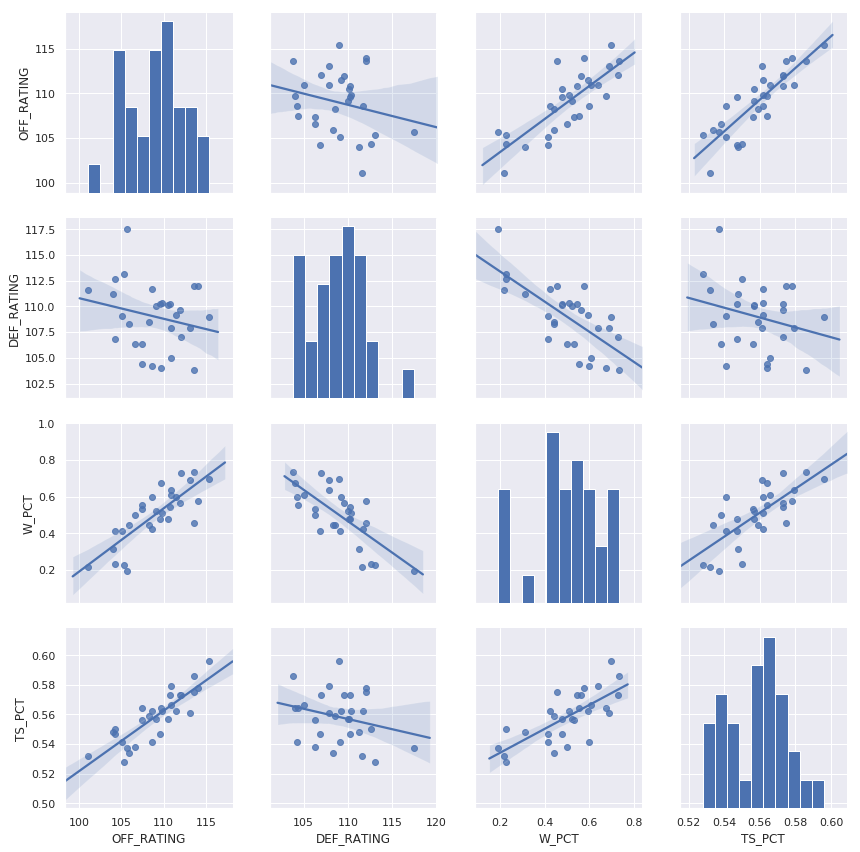

In [24]:
sns.set()
sns.pairplot(df, vars=['OFF_RATING', 'DEF_RATING', "W_PCT", 'TS_PCT'], kind="reg", height=3)

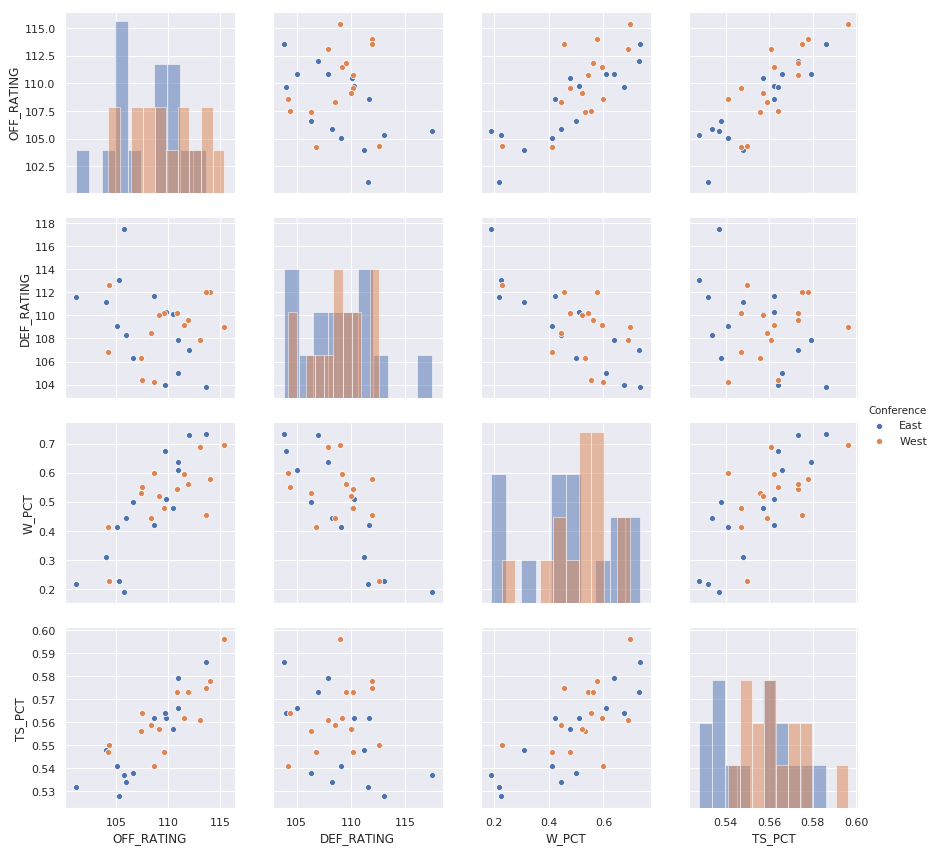

In [25]:
sns.pairplot(df, hue="Conference", vars=['OFF_RATING', 'DEF_RATING', "W_PCT", 'TS_PCT'], kind="scatter", diag_kind='hist', diag_kws={'alpha': 0.5}, height=3)

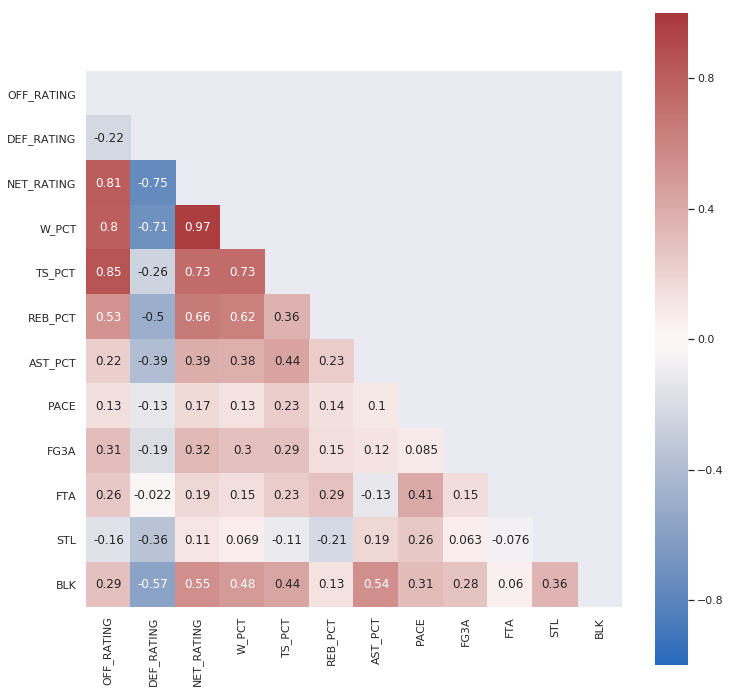

In [55]:
plt.figure(figsize = (12,12))
corr = df[['OFF_RATING', 'DEF_RATING', "NET_RATING", "W_PCT", 'TS_PCT', 'REB_PCT', 'AST_PCT', 'PACE', 'FG3A', 'FTA', 'STL', 'BLK']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, cmap='vlag', mask=mask, annot=True, square=True, vmin=-1, vmax=1)